As always we start with loading some packages and helper functions. Be sure that the file dataset.zip is unzipped.

In [ ]:
#unzip the data file
import zipfile
zip_ref = zipfile.ZipFile('dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [1]:
import numpy as np
import os

import matplotlib
from matplotlib import pyplot as plt
import skimage
import skimage.transform

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

vgg16 = models.vgg16(pretrained=True)

#model = models.resnet18(pretrained=True)
#model = models.alexnet(pretrained=True)
#model = models.squeezenet1_0(pretrained=True)
model = vgg16
#model = models.densenet161(pretrained=True)
#model = models.inception_v3(pretrained=True)

model.eval()
model.cpu() # In this module, we assume you don't have a GPU. That's fine, since we aren't going to train the networks, just use them to make predictions.

class_id_file = open("imagenet1000_clsid_to_human.txt", "r")
class_dict = eval(class_id_file.read())
class_id_file.close()

def normalize_image(img):
    mean = np.array([[[0.485, 0.456, 0.406]]])
    std = np.array([[[0.229, 0.224, 0.225]]])
    norm_const = 1.0 * img.max()
    img = img / norm_const # Normalize image between 0 and 1
    img = img - mean
    img = img / std
    return img


In this module, we will use the PyTorch framework for deep learning. If PyTorch is not already installed (this would cause an error in the previous code block), follow the installation instruction [at the PyTorch website](https://pytorch.org/). PyTorch is an excellent framework to learn. It balances ease of use with state of the art capabilities very well. It also comes with a number of pretrained deep neural networks. In this module, we will use PyTorch's pretrained VGG-16 network to demonstrate key concepts in deep learning.

# Machine Vision
## Using Pretrained Neural Networks

In the previous module, we introduced the basic concepts underlying neural networks. We started by looking at using individual neurons to perform classification tasks (Logistic Regression). After this we noted that we can add a hidden layer to allow the neural network to extract features in a trainable way.



In this module, we will have a look at using pretrained neural networks to perform image classification tasks. We will be using the VGG-16 neural network (the original scientific paper describing the network can be found [here](https://arxiv.org/pdf/1409.1556.pdf)). This network an example of a *deep neural network*. The neural network at the end of the previous module had only one hidden layer. A deep neural network is characterized by having many hidden layers (although what qualifies as "many" changes as the technology matures). The science (and to some extent art) of training a deep neural network is known as Deep Learning. 



The VGG-16 has been trained to work on the [ImageNet dataset](http://image-net.org/index). ImageNet is a huge collection of images containing diverse kinds of objects. Below are some sample images taken from certain classes within the larger dataset. 

![imagenet examples](figures/imagenet_samples.png)

VGG-16 takes an RGB image with a resolution of $224\times224$, and produces a prediction from 1000 output classes. One of the great advantages of using a pre-trained network is that you can actually often use it for your own problem. We will see in this notebook that the network VGG-16 detect basic features of image, like the  existence of an vertical edge. What often happens is that weights of the last few layers are *forgotten* and retrained whit your own data. This is called transfer-learning. Often remarkable good results are obtained this way, and it is relatively cheap. You need way less data than for the original task. 

To get an idea of how complex it is to distinguish all classes, have a look below at the list of 1000 classes. One of the subtleties is that image-net contains 120 different dogbreeds, and VGG-16 is quite well able to distinguish those.

In [2]:
def interact_classes(n=(0, 99)):
    for m in range(10):
        key = n * 10 + m
        print("%d : %s" % (key, class_dict[key]))
        
interact(interact_classes)

interactive(children=(IntSlider(value=49, description='n', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.interact_classes(n=(0, 99))>

Let's begin by looking at the structure of VGG16, as shown in the following figure. We will guide you through the meaning of the stages in the rest of the module. You should refer back to this figure as necessary.

![vgg16](figures/vgg16_structure.svg)



The figure is broken into two sections:
* Convolutional Stages
* Fully Connected Stages

The fully connected stages are structured in the same way as the neural network at the end of the last module. The major difference is that there are two hidden layers with 4096 hidden units each. The output layer has 1000 units instead of 10. This is because VGG-16 can detect a thousand different kinds of objects. Another difference is that we don't feed the input images directly to these layers. Instead, the input image is passed through the convolutional stages, which "distills" useful features from the input image, so that the fully connected stages have more informative features to work with.

So, the last section is not that new for you. There are more hidden layers, and more output classes, but otherwise this section is similar to the last module's neural network. These layers are known as *fully connected* layers, because each unit in a previous layer connects to each unit in the following layer.

The first part of VGG16, the convolutional stages, are something new. The main component of these stages are convolution operations. Recall from an earlier module that we used convolution for noise reduction and edge detection? In deep neural networks, convolutions are instead used as flexible feature extraction stages. In the earlier module, we fixed the convolution kernel based on the task we had in mind. Recall the difference between a blurring kernel and an edge detection kernel? In deep neural networks, we don't preset these kernels. Instead, we *learn* the kernels. The neural network may learn it needs to have a blurring or edge detection kernel, but this is all emerges automatically during the training process.

__Exercise__:
Look back how a convolution works.


Let's start with something fun. The following code block allows you to select images from the ImageNet validation set. These images were not seen by the training algorithm, so they can be used to gauge real-world performance of VGG-16. For class we selected 5 images representing the class, which you can see by the sliding the image_num bar. We show the input image on the right. On the left, we show the top 10 highest scoring classes obtained from the model (the top class is the one chosen by the classifier). 

__Execise__:
Have a look at the predictions made by the model for a variety of input images. 
* Find a 5 predictions that are wrong. Do you understand why they are wrongly classified?
* Is the correct prediction in the at least in the top 10.

The mistakes can be very interesting, because often you can see why the network might consider one of the incorrect classes as plausible.

NOTE: If you get the error "`resize() got an unexpected keyword argument 'anti_aliasing'`", you are likely using an older version of scikit-image, and you should update it. If you are using Anaconda, running `conda update scikit-image` in a terminal / command prompt should do the trick.

In [3]:
def make_interact_vgg():
    image_type_slider = widgets.IntSlider(min=0,max=999,step=1,value=9)
    image_num_slider = widgets.IntSlider(min=0,max=4,step=1,value=0)

    def interact_vgg(image_type = image_type_slider, image_num = image_num_slider):
        plt.rcParams["figure.figsize"] = (10,5)
        image_files = os.listdir("dataset/%d" % image_type)
        image_file = "dataset/%d/%s" % (image_type, image_files[image_num])
        raw_image = plt.imread(image_file)
        if (raw_image.shape[0:2] == (224,224)):
            # No resizing needed
            rescaled_image = raw_image
        else:
            # Need resizing
            rescaled_image = skimage.transform.resize(raw_image, (244,244), mode="constant", anti_aliasing=True)
        plt.subplot(1,2,2)
        plt.imshow(rescaled_image)
        plt.title(class_dict[image_type])
        normalized_image = normalize_image(rescaled_image)
        transposed_image = normalized_image[np.newaxis,:,:,:]
        transposed_image = transposed_image.transpose((0,3,1,2)).astype(np.float32)
        input_tensor = torch.tensor(transposed_image)
        output = vgg16(input_tensor).detach().numpy()[0]

        top_n = 10
        descending_sorted_indices = np.argsort(output)[::-1]    

        scores = output[descending_sorted_indices[:top_n]]

        labels = []
        for n in range(10):
            labels.append(class_dict[descending_sorted_indices[n]])
        plt.subplot(1,2,1)
        plt.barh(labels[::-1], scores[::-1])
    return interact_vgg
    
interact(make_interact_vgg())
    

interactive(children=(IntSlider(value=9, description='image_type', max=999), IntSlider(value=0, description='i…

<function __main__.make_interact_vgg.<locals>.interact_vgg(image_type=IntSlider(value=9, description='image_type', max=999), image_num=IntSlider(value=0, description='image_num', max=4))>

Let's start looking at VGG-16 in more detail. We can ask PyTorch to print out a description of the network using the following statement. Be warned, it is a rather large network.

In [4]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

That's seems rather a lot to take in. But, you already have the skills you need to follow how the network operates.

Firstly, in the above printout, note that there are two sections ("features" and "classifier"). These correspond to the "convolutional stages" and "fully connected stages" mentioned in the diagram of VGG-16 shown earlier in the notebook.

Let's begin by discussing the "features" section. The very first layer has the description:

`Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))`

This layer is just a set of two-dimensional convolution operations. Recall that we have previously looked at two-dimensional convolution operations in image processing. Let's go through the meaning of each parameter passed to Conv2d:

- 3:  The input image is an RGB image, so it has three channels, one for red, one for green and one for blue.
- 64: We will perform 64 convolutions on the input image. Each of those 64 convolutions has its own kernel. Because there are 64 convolutions, the output of this layer will have 64 channels. You can just think of this as a special kind of image, except that instead of the 1 channel for grayscale images, or the 3 channels for RGB images, there are 64 channel. These channels correspond to (what should be) more informative features than raw RGB values. One of the 64 channels might represent horizontal edges in the input image. Another channel might represent regions in the input image that are predominantly red.
- kernel_size=(3,3): Recall that convolutions are defined by a kernel, and that these kernels are a matrix of numbers. This parameter says each of the 64 kernels is 3-by-3 in terms of their dimensions along the horizontal and vertical axes of the image. Hidden here is that the kernels will also have 3 *channels*, because the input image has three colour channels. In our previous module, we only worked with grayscale images, so there was only one channel. There's nothing new about a kernel that has multiple channels. You do the convolution for the corresponding channels of the input and the kernel separately, and the add together all of the convolved images. We will visualize this for you shortly.
- stride=(1,1): (Optional material) It is sometimes useful to skip pixels to make the output have a smaller width and height. A stride of (2,2) would have halved the width and height of the output image from the layer. In VGG-16, this is done with the specialized `MaxPool2d` layers, so you don't need this to understand the convolutional stages.
- padding=(1,1): (Optional material) The padding parameter is relevant at the edges of the image. Recall that the kernel may overlap with regions *outside* the original input image when you look at the edges of the input image. A padding of (1,1) says we pretend that there is a border of black pixels around the input, and that this border has a thickness of 1. Since the kernels are (3,3), this means that convolution can be performed at each point in the original input image. This is because a 3x3 kernel overlaps at most 1 pixel outside the original area of the input image, and so this extra overlap is completely dealt with by the extra black border pixels. 

Let's visualize what the first convolutional layer does exactly. We start by loading up a test image, which we will use in the rest of the module as a case study.

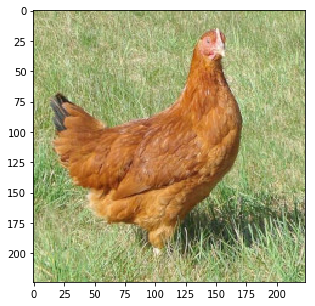

In [5]:
hen_image = plt.imread("figures/hen_sample_224.jpg")
plt.imshow(hen_image)


The following piece of code does some preperatory work for our visualization code. It extracts the output of the first convolutional layer. It also breaks up the convolution into the separate red, green and blue components.

It is *NOT* important that you understand how the code works, the subsequent visualization is what you should focus on.

In [6]:
def get_layer_one_features_and_filters(img):
    hen_tensor = torch.tensor(normalize_image(img).astype(np.float32)[np.newaxis,:,:,:].transpose((0,3,1,2)))
    layer_1_feats = vgg16.features[0].forward(hen_tensor).detach().numpy()
    filters_1 = vgg16.features[0].weight.detach().numpy()
    return layer_1_feats, filters_1

def get_layer_one_channel_activations(img, channel):
    temp_img = normalize_image(img)
    img = np.zeros_like(temp_img)
    img[:,:,channel] = temp_img[:,:,channel]
    hen_tensor = torch.tensor(img.astype(np.float32)[np.newaxis,:,:,:].transpose((0,3,1,2)))
    bias = dict(vgg16.features[0].named_parameters())["bias"]
    layer_1_feats = vgg16.features[0].forward(hen_tensor).detach().numpy() - bias.detach().numpy()[np.newaxis,:,np.newaxis,np.newaxis]
    return layer_1_feats

float_hen = hen_image 
red_hen = float_hen.copy()
red_hen[:,:,[1,2]] = 0
green_hen = float_hen.copy()
green_hen[:,:,[0,2]] = 0
blue_hen = float_hen.copy()
blue_hen[:,:,[0,1]] = 0

layer_1_feats, filters_1 = get_layer_one_features_and_filters(float_hen)
layer_1_feats_red = get_layer_one_channel_activations(float_hen, 0)
layer_1_feats_green = get_layer_one_channel_activations(float_hen, 1)
layer_1_feats_blue = get_layer_one_channel_activations(float_hen, 2)


In the below code cell, we visualize the working of the first convolution layer. First off, you need to see that two-dimensional convolution of RGB images can be broken up into 3 two-dimensional convolutions of the color channels, with each color channel seen as an independent grayscale image. We demonstrate this by showing the red, green and blue channels of the input image on the left. Just to the right of each channel, we visualize the 3x3 kernel applied to the red, green and blue channels (red means the kernel is positive, blue means the kernel is negative, white means it is close to 0). The the right of this, we show the result of the two-dimensional convolutions of each of the color channels (green means a pixel has a positive value, magenta means that the pixel has a negative value, white means the pixel is close to zero). Finally, we get the output of the layer for the given kernel by adding the result of each channel's separate convolution results. This we visualize in the rightmost image.

In [ ]:
weights_cmap = "bwr"
activations_cmap = "PiYG"

kernel_slider = widgets.IntSlider(min=0,max=63,step=1,value=0)

def plot_vgg16_first_feature_maps(kernel_number = kernel_slider):
    n = kernel_number
    plt.rcParams["figure.figsize"] = (20,15)
    plt.subplot(3,4,1)
    zero_channel = np.zeros_like(hen_image[:,:,0])
    plt.imshow(red_hen,vmin=0, vmax=1)
    plt.title("Input Image Red Channel")
    plt.subplot(3,4,5)
    plt.imshow(green_hen,vmin=0, vmax=1)
    plt.title("Input Image Green Channel")
    plt.subplot(3,4,9)
    plt.imshow(blue_hen,vmin=0, vmax=1)
    plt.title("Input Image Blue Channel")

    vrange = np.abs(filters_1[n]).max()

    plt.subplot(3,4,2)
    plt.imshow(filters_1[n][:,:,0], vmin = (-vrange), vmax = vrange, cmap=weights_cmap)
    plt.title("Red Component of Kernel %d" % n)
    plt.xticks([0,1,2])
    plt.yticks([0,1,2])
    plt.subplot(3,4,6)
    plt.imshow(filters_1[n][:,:,1], vmin = (-vrange), vmax = vrange, cmap=weights_cmap)
    plt.title("Green Component of Kernel %d" % n)
    plt.xticks([0,1,2])
    plt.yticks([0,1,2])
    plt.subplot(3,4,10)
    plt.imshow(filters_1[n][:,:,2], vmin = (-vrange), vmax = vrange, cmap=weights_cmap)
    plt.title("Blue Component of Kernel %d" % n)
    plt.xticks([0,1,2])
    plt.yticks([0,1,2])

    frange = 0
    feature_map = layer_1_feats_red[0][n]
    frange = max(frange, np.abs(feature_map).max())
    feature_map = layer_1_feats_green[0][n]
    frange = max(frange, np.abs(feature_map).max())
    feature_map = layer_1_feats_blue[0][n]
    frange = max(frange, np.abs(feature_map).max())
    feature_map = layer_1_feats_blue[0][n]
    frange = max(frange, np.abs(feature_map).max())

    plt.subplot(3,4,3)
    feature_map = layer_1_feats_red[0][n]
    feature_map = 0.5 + feature_map / frange / 2
    plt.imshow(feature_map, cmap=activations_cmap, vmin=0, vmax=1)
    plt.title("Ar = Red Activations" )
    plt.subplot(3,4,7)
    feature_map = layer_1_feats_green[0][n]
    feature_map = 0.5 + feature_map / frange / 2
    plt.imshow(feature_map, cmap=activations_cmap, vmin=0, vmax=1)
    plt.title("Ag = Green Activations" )
    plt.subplot(3,4,11)
    feature_map = layer_1_feats_blue[0][n]
    feature_map = 0.5 + feature_map / frange / 2
    plt.imshow(feature_map, cmap=activations_cmap, vmin=0, vmax=1)
    plt.title("Ab = Blue Activations" )

    #plt.subplot(1,4,3)
    
    #kernel_image = 0.5 + filters_1[n] / vrange / 2 
    #plt.imshow(kernel_image)
    ##plt.imshow((filters_1[n] - vmin) / (vmax - vmin))
    #plt.title("Convolutional Kernel %d" % n)
    #plt.gca().axis("off")
    plt.subplot(1,4,4)
    #mn = feature_map.min()
    #mx = feature_map.max()
    #feature_map = (feature_map - mn) / (mx - mn)
    feature_map = layer_1_feats[0][n]
    frange = np.abs(feature_map).max()
    feature_map = 0.5 + feature_map / frange / 2
    plt.imshow(feature_map, cmap=activations_cmap, vmin=0, vmax=1)
    plt.title("Feature Map %d (Ar + Ag + Ab + bias)" % n)
    plt.show()
        
interact(plot_vgg16_first_feature_maps)

Play around by selecting different kernels and seeing what the output convolution is, but also what is happening in each of the color channels. Look at the different functions that the kernels are performing. 
__Exercise__: Find some kernels that:
* find edges in a particular direction
* find a region of a particular color.
Have a close look at these particular kernels, do you see why these are helpful?

You may be wondering why *convolution* qualifies as part of a neural network? There is a hint at how this works by looking at the color schemes adopted in the previous visualization. The kernels were visualized using the blue/white/red colour scheme used for visualizing neuron weights in the previous module. The convolution results are visualized using the magenta/white/green scheme used to visualize neuron outputs in the previous module. This choice is deliberate because they in fact are exactly those same things! You can imagine a convolution as a tiny neural network being applied at each pixel in the image. In effect, there is one neuron per output pixel, and each neuron is identical. 

The tiny neural network in our current example takes as its input only a 3x3 image (with the 3 RGB channels) from around the input pixel corresponding to the given output pixel. The 3x3 kernel (with its 3 RGB channels) corresponds to the connection weights for each of those pixels. The output activations are the output of the neuron given the tiny input image. The red, green and blue activations are partial sums of the total sum the output neuron produces.

Let's reproduce the diagram we used to illustrate convolution in an earlier module:

![convolution](figures/convolution.png)

Looking at this diagram, look at the 3x3 block of pixels in the input image as the input dendrites of a neuron. The 3x3 kernel values are the connection strengths of each of those 3x3 input dendrites. We multiply the input pixels by their connection strengths, and then add them all together to produce an output pixel. We repeatedly use this tiny neural network to produce each output pixel. This has a number of advantages:
* We know convolution is useful in image processing tasks, so they should be useful for a neural network performing image classification tasks.
* The convolutions we are using are defined entirely by their tiny 3x3 kernels. Because there are 3 channels, there are only 3x3x3=27 connections strengths to train in an image that has 224x224x3=150528 input pixel channel values. Training that larger number of weight directly wouldn't be practical, and also almost certainly not desirable. Models that are too flexible (have too many weights) often learn to memorize the training data instead of *understanding* the input data. 
* Because convolution does the same small operation at each point of the image, all parts of the image are treated in exactly the same way. This is useful, for example, we should still see a car in one corner of an image as a car if we move it to another corner. The same features that are useful in one region of the image should still be useful when calculated in other parts of the input image.
* Convolution is fast. With a small kernel size like 3x3, it can be performed rapidly.


### Kernel visualization (optional material)
Before continuing, let's visualize the 64 kernels in the first convolutional layer as RBG images. In contrast to the blue/white/red visualization of the separate channels, this allows us to see simultaneously how each kernel treats grayscale information and color information. This kind of visualization is quite common in technical writing about neural networks, so it is good to be familiar with it. It is not so important that you immediately grasp what all of these plots mean, it's more important that you know that such visualizations are possible, and that you might encounter them in other texts.

The code block below gives you two options. The first option (with absolute_value turned off) rescales the kernel so that values range from 0.0 to 1.0, and zero in the original kernel maps to 0.5. Values below 0.5 (which appear dark) are where the kernel itself is negative and values above 0.5 are where the kernel itself is positive (appear bright). A kernel with 0 weights everywhere would appear mid-level gray. A kernel that treats all colors the same, would be grayscale. If a kernel is colored, it is because the color channels are treated differently, and the color you are seeing indicates the balance between the color channel weights. A bit of tricky aspect in interpreting these images is that dark pixels indicate strong *NEGATIVE* weights/sensitivities, and light pixels indicate strong *POSITIVE* weights/sensitivities. Again, mid-level gray or color intensity (0.5) represents zero weights/sensitivities.

The second option (with absolute_value turned on), is easier to understand, but is less common in literature. We take the absolute value of a kernel, scale it so that all values lie between 0 and 1, and then display the kernel as an image. If a pixel is green, it means that the kernel is "interested" in green. The lighter the color, the more sensitive the kernel is for that color (the connection weight is bigger). But, there is no indication of whether green is treated as excitory or inhibiting (we lose this information by taking the absolute value of the kernel). 

In [7]:
def vis_rgb_kernel(kernel, absolute_val):
    vrange = np.abs(kernel).max() * 1.0
    if (absolute_val):
        return np.abs(kernel) / vrange
    else:
        return 0.5 + 0.5 * (kernel / vrange)

def plot_vgg16_kernels(absolute_value=False):
    filters = vgg16.features[0].weight.detach().numpy()
    
    for n in range(64):
        plt.subplot(8,8,n+1)
        plt.imshow(vis_rgb_kernel(filters[n], absolute_value))
        plt.gca().axis("off")
        plt.title("n=%d"% n)

plt.rcParams["figure.figsize"] = (15,15)
interact(plot_vgg16_kernels)

interactive(children=(Checkbox(value=False, description='absolute_value'), Output()), _dom_classes=('widget-in…

<function __main__.plot_vgg16_kernels(absolute_value=False)>

There is a particularly nice example in an older deep neural network called AlexNet ([original paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)). It's structure looks a bit more complex, and is diagrammed below.

![AlexNet](figures/alexnet.png)

This looks a bit complex, but basically there are parallel convolutional pipelines at the top and bottom of the figures, with occasional connections between the two pipelines. The reason for this was practical. At the time Alexnet was published, Graphics Processing Units (GPUs) (heavily used in deep learning for making calculations a lot faster) had much less capacity, and the neural network had to be split across two separate GPU cards. One card was used for the top pipeline, the other for the bottom pipeline.

There are two first convolution stages, one above and one below. Each of these has 48 kernels. These kernels are visualized in the following figure (the top three rows belong to the top pipeline, the bottom three rows belong to the bottom pipeline).

![AlexNet Features](figures/alexnet_filters.jpg)

Firstly, the kernels are 11x11, so its easier to see structure here. There are a few interesting things to notice:
* The top three rows of filters are mostly grayscale, the bottom filters are mostly color. This is remarkable, because it means that the top and bottom pipelines have learned, by themselves, to focus more on grayscale (edge) information and color information respectively. This emerged from the fact that the two pipelines are not strongly connected.
* The top three rows of filters are all little wavey grayscale patterns, with the waves going in different directions depending on which kernel you're looking at. These kernels act as edge detectors, and are called Gabor-like kernels. The thinner the waves are (with more repetitions), the smaller the edges are that kernel is looking for. The kernel tries to find edges in the direction perpendicular to the waves it is built from. What is remarkable these filters is that the early parts of the human visual system actually contain cells with sensitivities patterns similar to these. The network learned this automatically, without any guidance in this direction. This suggests that there is at least some connection between how deep neural networks operate and the actual neural network in the visual pathways.

# Deeper into VGG-16

In this section, we will begin exploring the deeper layers of VGG-16 in order to get an idea of what the different layers do. Let's print out the structure of VGG-16 again.

In [ ]:
vgg16

In the "features" section, you can see there are three kinds of layers:
- Conv2d : These are convolutions as we just discussed
- ReLU: This is a non-linearity, a bit like the sigmoid function in the previous module. We will discuss this shortly.
- MaxPool2d: This is a layer that shrinks images passing through by a factor of 2 in both the horizontal and vertical directions. We'll discuss this shortly as well.

Let's examine the features as they pass through the network. We start by keeping a record of all features in the case of the test image. The following code block does this for us (you don't have to examine the code for the purpose of this module).

In [ ]:
def get_all_layer_features(img):
    layer_features = []
    pre_features = []
    every_layer_features = []
    hen_tensor = torch.tensor(normalize_image(img).astype(np.float32)[np.newaxis,:,:,:].transpose((0,3,1,2)))
    
    last_features = hen_tensor
    layer_features.append(last_features.detach().numpy().copy())
    
    every_layer_features.append((None, last_features.detach().numpy().copy()))
        
    for n in range(len(vgg16.features)):
        this_layer = vgg16.features[n]
        if (type(this_layer) == torch.nn.modules.conv.Conv2d):
            pre_features.append(last_features.detach().numpy().copy()) # Copy is necessary, because pytorch does ReLU in-place
        last_features = this_layer.forward(last_features)
        every_layer_features.append((this_layer, last_features.detach().numpy().copy()))
        if (type(this_layer) == torch.nn.modules.conv.Conv2d):
            layer_features.append(last_features.detach().numpy().copy()) # Copy is necessary, because pytorch does ReLU in-place
    pre_features.append(last_features.detach().numpy().copy())

    return layer_features, pre_features, every_layer_features

hen_features, hen_features_rectified, hen_every_layer_features = get_all_layer_features(float_hen)

Now, let's have a look at the features at various stages in the network. The following code block allows you to choose a layer in the neural network. It then can show you any feature map channel at that point in the network. We will use this tool as a means of explaining the functioning of the layers. Play around with the tool to become familiar with how it works, then proceed to the sections following it.

In [ ]:
weights_cmap = "bwr"
activations_cmap = "PiYG"

def print_layer(layer, feats, depth):
    if (layer == None):
        print('{:<80}'.format(" -1. Input Image"), end=" : ")
    else:
        print('{:<80}'.format(" %2d. %s" % (depth-1, layer)), end=" : ")
    print("Size %dx%d with %d channels." % (feats.shape[2], feats.shape[3], feats.shape[1]))

def print_where(layers_and_feats, depth):
    radius = 2
    before = layers_and_feats[max(depth-radius,0):depth]
    current = layers_and_feats[depth]
    after = layers_and_feats[depth+1:depth+radius+1]
    
    current_depth = max((depth - radius), 0)
    for x in before:
        print("    ", end="")
        print_layer(x[0], x[1], current_depth)
        current_depth = current_depth + 1

    print("--> ", end="")
    print_layer(current[0], current[1], current_depth)
    current_depth = current_depth + 1
    
    for x in after:
        print("    ", end="")
        print_layer(x[0], x[1], current_depth)
        current_depth = current_depth + 1

def make_all_feature_map_plotter():
    depth_slider = widgets.IntSlider(min=0,max=len(hen_every_layer_features)-1,step=1,value=0)
    feature_map_slider = widgets.IntSlider(min=0,max=512,step=1,value=0)
    def plot_vgg16_all_feature_maps(depth=depth_slider, feature_map=feature_map_slider):
        features = [features for layer, features in hen_every_layer_features]

        #layer_features.append(last_features.detach().numpy().copy())

        num_maps = len(features[depth][0])
        feature_map_slider.max = num_maps - 1
        feature_map_slider.value = min(num_maps - 1, feature_map_slider.value)

        n = feature_map_slider.value

        print_where(hen_every_layer_features, depth_slider.value)

        plt.rcParams["figure.figsize"] = (20,10)
        plt.subplot(1,2,1)
        plt.imshow(hen_image)
        plt.title("Input Image")

        plt.subplot(1,2,2)
        fmap = features[depth][0][n]
        frange = np.abs(fmap).max()
        if (frange != 0):
            fmap = 0.5 + fmap / frange / 2
        else:
            fmap = 0.5 + fmap / 1e-16 / 2
        plt.imshow(fmap, cmap=activations_cmap, vmin=0, vmax=1)
        plt.title("Output Feature Map Channel %d at Depth %d" % (n, depth-1))
        plt.show()
    return plot_vgg16_all_feature_maps
        
interact(make_all_feature_map_plotter())

## Rectified Linear Units (ReLU)

Recall from the previous module that our neuron output went through a sigmoid curve? In practice, the sigmoid function is just one of a number of alternatives. In this module, we encounter a particularly popular alternative, rectified linear units (abbreviated as ReLU units).

Consider the following figure that places the output curve of a sigmoidal unit and a rectified linear unit next to each other.

![sigmoid and relu](figures/sigmoid_relu.png)

You can see that a sigmoid is a smooth curve that is limited between 0 and 1. By contrast, a rectified linear unit is composed of two straight lines, with a sharp corner at $z=0$. Furthermore, you can see that a rectified linear unit's output has a minimum value of 0, but has no maximum value (when $z$ is positive, the output is as big as $z$ is).

Notice that in the "features" section of VGG-16, the only non-linearity in use is ReLU. What's the advantage of using ReLU units then? We mention two key points:
* ReLUs outputs are *MUCH* easier to calculate than sigmoidal outputs. To calculate a ReLU output, you simply check if the input is postive. If not, the output is zero. If the input is positive, then the output is the same as the input. By contrast, calculating values on the sigmoidal curve accurately takes a *much* larger number of steps.
* ReLU units work particularly well with images, because they provide better tolerance of different lighting conditions.

Recall in the last module, you interacted with a single neuron with a sigmoidal output curve. Below we repeat that exercise, but make use of a ReLU non-linearity instead. Play around with the controls to get a feeling for how such a neuron reacts.

In [8]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def make_cmap_plotter(colormap):
    def plotter(w, force_range = None, aspect=None):
        w = np.array(w)
        assert (w.ndim < 4), "w must have dimensionality less than 4"
        if (w.ndim == 0):
            w = np.array([[w]])

        if (w.ndim == 1):
            w = np.array([w])

        if (w.ndim == 2):
            if (force_range is None):
                w_range = np.abs(w).max()
            else:
                w_range = force_range
            plt.imshow(w, cmap=colormap, vmax=w_range, vmin=-w_range, aspect=aspect)    
            return

        grid_length = np.ceil(np.sqrt(w.shape[0]))

        for n in range(w.shape[0]):
            plt.subplot(grid_length,grid_length,n+1)
            vrange = np.abs(w).max()
            plt.imshow(w[n], cmap=colormap, vmax=vrange,vmin=-vrange, aspect=aspect)
            plt.title("n=%d" % (n+1))
    return plotter

weights_cmap = "bwr"
plot_weights = make_cmap_plotter(weights_cmap)

activations_cmap = "PiYG"
plot_activations = make_cmap_plotter(activations_cmap)

w = np.array([2, 4, -2, 0, -4])

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def linear(x):
    return x

def relu(x):
    return (x >= 0) * x

def arctan(x):
    return np.arctan(x)

interact_activation = relu


def interact_neuron(x1 = (0.0, 1.0), x2=(0.0, 1.0), x3=(0.0, 1.0), x4=(0.0, 1.0), x5=(0.0, 1.0)):
    plt.rcParams["figure.figsize"] = (20,10)
    x = np.array([x1, x2, x3, x4, x5])
    z = w[0] * x[0] + w[1] * x[1] + w[2] * x[2] + w[3] * x[3] + w[4] * x[4]
    y = interact_activation(z)
    
    max_z = np.sum((w > 0) * w)
    min_z = np.sum((w < 0) * w)
    zs = np.linspace(min_z, max_z, 100)
    
    plt.subplot(1,6,1)
    plt.imshow(np.array([x]).T, cmap="gray", vmin=0.0, vmax=1.0)
    plt.title("Input Image (x)")
    for n in range(x.shape[0]):
        plt.gca().annotate("x[%d]=%.2f" % (n, x[n]), xy=(0,n), horizontalalignment='center', color="g")
    plt.axis("off")
    plt.subplot(1,6,2)
    plot_weights(np.array([w]).T)
    for n in range(w.shape[0]):
        plt.gca().annotate("w[%d]=%.2f" % (n, w[n]), xy=(0,n), horizontalalignment='center')
    plt.title("Pixel Weights (w)")
    plt.axis("off")
    plt.subplot(1,6,3)
    plot_activations(np.array([x*w]).T, force_range = max(max_z, -min_z))
    for n in range(w.shape[0]):
        plt.gca().annotate("x[%d]w[%d]" % (n, n), xy=(0,n-0.25), horizontalalignment='center')
        plt.gca().annotate("%.2f" % (x[n]*w[n]), xy=(0,n+0.25), horizontalalignment='center')
    plt.title("Weighted Inputs (x*w)")
    plt.axis("off")
    plt.subplot(1,2,2)
    plt.plot(zs, interact_activation(zs), 'k-')
    plt.plot([z],[y], 'ro',markersize=20)
    
    plt.title("Neuron Output: a = ReLU(np.sum(w * x)) = %f" % y)
    plt.ylabel("y = ReLU(z)")
    plt.xlabel("z = np.sum(w * x)")
    plt.legend(["ReLU(z)"])
    plt.grid()
    
    
interact(interact_neuron, x1=0.0, x2=0.0, x3=0.0, x4=0.0, x5=0.0)

interactive(children=(FloatSlider(value=0.0, description='x1', max=1.0), FloatSlider(value=0.0, description='x…

<function __main__.interact_neuron(x1=(0.0, 1.0), x2=(0.0, 1.0), x3=(0.0, 1.0), x4=(0.0, 1.0), x5=(0.0, 1.0))>

How can we see this at work? In the below code cell, we repeat the visualization of feature maps from earlier on. Find yourself a convolutional layer and a feature map channel at the layer output which has contains both green and magenta (both positive and negative values). Change between the convolutional layer and the following ReLU layer. See that the white and green outputs stay the same, but all the magenta outputs disappear (become white) after the ReLU? That's because magenta represents negative values in the feature maps. The ReLU layer lets all values positive values pass, but replaces all negative values with 0 (displayed as white). Note: The rectified signal's green might appear more intense than the unrectified version. This happens when the unrectified feature map has negative values whose absolute value exceeds the maximum positive value in the feature map. So, don't worry about the green color intensities changing, they are actually still the same values.

In [ ]:
interact(make_all_feature_map_plotter())

## Max Pooling

You will have noticed some of the layers are MaxPool2d layers. These are special layers that shrink the spatial image dimensions of the feature maps so that the width and height are less. In the case of VGG-16, this shrinking is a factor of 2. The way max pooling works is that the layer looks at groups of 4 pixels. It chooses the maximum value amongst those 4 pixels, and then discards the rest. The following figure illustrates this process.

![max pooling](figures/maxpooling.png)

Why is this useful?
* Convolutions look only at a small part of the image (in the case of VGG-16, 3x3 blocks of pixels). Because the image shrinks by a factor of 2, suddenly convolutions have a longer spatial reach relative to the original image, while the kernel size remains the same. This allows later layers in the network to represent and process information about large areas in the input image.
* Max pooling creates a mechanism by which a layer can "shout" that something interesting has been found in a particular part of the image. Because the loudest "shout" is always heard by the later layers, this means that interesting aspects of an image don't get "diluted" by uninteresting parts as one would get when taking the average over a group of pixels instead of the maximum.

We repeat the earlier feature map visualization below. Find yourself a MaxPool2d layer. Compare the output from the preceding layer to the output of the MaxPool2d layer itself. Can you see how the feature maps are shrunk? Look carefully at the change resolution (as seen on the x- and y axis ticks).

In [ ]:
interact(make_all_feature_map_plotter())

# Fully Connected Stage

In the feature map visualization, have a look at the feature maps at the maximum depth (so, the output of the layer just before the fully connected (or classifier) stage.

You should see that the feature maps are really blocky (7x7). There are quite a lot of channels though, 512 to be precise.

Let look at this from the perspective of the previous module. There we fed MNIST digits to a fully connected neural network with one hidden layer. The input images were 28x28, and grayscale (so only 1 channel).  In VGG-16, the spatial resolution of the "image" going into the first fully connected layer is only 7x7, but it has many more channels (512). There's another major difference. With the MNIST example, we could see exactly what the input image "means" by visualizing it. In VGG-16, the feature maps are really abstract. They have been trained so that they are very informative for the classification task, but at this point a human can't really tell what the features mean any more (at least, not without some deep exploration and extra experiments). This is why neural networks are sometimes referred to as "black box" techniques. Because we can't really tell reliably what the inner layers of a neural network are doing, their functioning is effectively hidden in a "box" of complexity. 

Fortunately, we don't have to worry about understanding these feature maps ourselves, that is the job of the fully connected "classifier" stage. We are, in fact, in a better position, as the fully connected stage now has more informative features to work with than just a raw image. In the MNIST example, the fully connected layers had to perform feature extraction on the image itself, in VGG-16 and other deep networks most of that task is handled by the convolutional stages.  

In the MNIST example, the 28x28x1 image was flattened into a $28\times 28 \times 1 = 784$ one-dimensional sequence of features. Similarly, the 7x7x512 is flattened into a $7\times 7 \times 512 = 25088$ one dimensional sequence of features. Following this flattening, these features are passed to a hidden layer with 4096 neurons, then another with 4096. The final decision is made in the output layer with 1000 neurons, one for each class.

# Deep Neural Network Architecture Diagrams

Diagrams of the following type are quite common in neural network literature.

![vgg16](figures/vgg16_structure.svg)

These figures indicate the size of the feature maps (their spatial dimensions and also how many channels the feature maps have).

As an exercise, look at the structure of VGG16 below and match the each block from the figure to a layer within the structure below. You can also use the feature map visualization tool to get the size of the feature map outputted at each layer.

In [ ]:
vgg16

In [ ]:
interact(make_all_feature_map_plotter())

# Further Exploration

The following code blocks allow you to explore feature maps within VGG-16, but also allows you to change the input image. Additionally, it allows you to choose particular image classes. This allows you to see whether there are patterns within the feature maps. Note that the code has been written to only extract features when the image file changes. This means that you can change the depth and channel fairly quickly without causing VGG-16 to be run. If you change the image itself, the change will be a bit slower because the new image needs to pass through VGG-16. However, changing the image will not change the depth or feature map channel, so you can check whether there are any regularities in the feature maps.

First we define the necessary code for the visualizations (but we do not start the visualization in this block yet).

In [ ]:
def get_final_features(img):
    every_layer_features = []
    img_tensor = torch.tensor(normalize_image(img).astype(np.float32)[np.newaxis,:,:,:].transpose((0,3,1,2)))
    
    last_features = img_tensor
    
    every_layer_features.append((None, last_features.detach().numpy().copy()))
        
    for n in range(len(vgg16.features)):
        this_layer = vgg16.features[n]
        last_features = this_layer.forward(last_features)
        every_layer_features.append((this_layer, last_features.detach().numpy().copy()))

    return every_layer_features

hen_features, hen_features_rectified, hen_every_layer_features = get_all_layer_features(float_hen)
def make_selected_image_all_feature_map_plotter():
    image_class_slider = widgets.IntSlider(min=0,max=999,step=1,value=8)
    image_number_slider = widgets.IntSlider(min=0,max=4,step=1,value=0)
    depth_max = len(hen_every_layer_features)-1
    depth_slider = widgets.IntSlider(min=0,max=depth_max,step=1,value=depth_max)
    feature_map_slider = widgets.IntSlider(min=0,max=512,step=1,value=0)
    
    current_class = -1
    current_image_number = -1
    current_image_files = []
    every_layer_features = None
    image_file = None
    
    def validate_features(image_class, image_number):
        nonlocal current_class, current_image_number, current_image_files, every_layer_features, image_file
        if (image_class != current_class):
            current_image_files = os.listdir("dataset/%d" % image_class)
        
        if ((image_class != current_class) or (image_number != current_image_number)):       
            current_class = image_class
            current_image_number = image_number
            
            image_file = "dataset/%d/%s" % (image_class, current_image_files[image_number])
            raw_image = plt.imread(image_file)
            if (raw_image.shape[0:2] == (224,224)):
                # No resizing needed
                rescaled_image = raw_image
            else:
                # Need resizing
                rescaled_image = skimage.transform.resize(raw_image, (244,244), mode="constant", anti_aliasing=True)

            every_layer_features = get_final_features(rescaled_image)
            image_file = rescaled_image
            
    
    def plot_vgg16_all_feature_maps(image_class = image_class_slider, image_number=image_number_slider, depth=depth_slider, feature_map=feature_map_slider, superimpose_features=True):
        nonlocal image_class_slider, image_number_slider, depth_slider, feature_map_slider
        nonlocal current_class, current_image_number
        nonlocal every_layer_features, image_file
            
        validate_features(image_class, image_number)
            
        features = [features for layer, features in every_layer_features]

        #layer_features.append(last_features.detach().numpy().copy())

        num_maps = len(features[depth][0])
        feature_map_slider.max = num_maps - 1
        feature_map_slider.value = min(num_maps - 1, feature_map_slider.value)

        n = feature_map_slider.value

        print_where(every_layer_features, depth_slider.value)

        plt.rcParams["figure.figsize"] = (20,10)

        plt.subplot(1,2,2)
        fmap = features[depth][0][n]
        frange = np.abs(fmap).max()
        if (frange != 0):
            fmap = 0.5 + fmap / frange / 2
        else:
            fmap = 0.5 + fmap / 1e-16 / 2
        plt.imshow(fmap, cmap=activations_cmap, vmin=0, vmax=1)
        plt.title("Output Feature Map Channel %d at Depth %d" % (n, depth-1))
        plt.subplot(1,2,1)
        if (superimpose_features):
            resize_fmap = skimage.transform.resize(fmap, image_file.shape[:2], mode="constant", anti_aliasing=False, order=0)
            grays = skimage.color.rgb2gray(image_file)
            superimposed = np.dstack([grays, resize_fmap, grays])
            plt.imshow(superimposed)
            plt.title("Input (With Superposition): %s" % class_dict[image_class])
        else:
            plt.imshow(image_file)
            plt.title("Input (Without Superposition): %s" % class_dict[image_class])
    
        plt.show()
    return plot_vgg16_all_feature_maps
        

You may use the following slider to search for interesting image clases.

In [ ]:
interact(interact_classes)

The following block does the actual visualization.

In [ ]:

interact(make_selected_image_all_feature_map_plotter())

# Further Reading

You now have a high-level knowledge of how a deep neural network operates. There's actually a great variety of neural network structures, but for image processing the structures you have learnt about occur again and again. If you interested in learning more about deep learning, a good place to start is the PyTorch website. There is [a series of tutorials](https://pytorch.org/tutorials/) on the website which show how to create *and train* a variety of neural networks. 

If you are looking for interesting problems to solve, you can have a look at the [Kaggle](https://www.kaggle.com/) website, which runs a lot of data science competitions, some with cash prizes.

## Clean your data after use:


In [ ]:
import shutil

shutil.rmtree('dataset')